In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from dataclasses import dataclass

In [2]:
model = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(4)
])

In [3]:
@dataclass(frozen=True)
class ExprimentConfig:
    title: str

    p_range: tuple[float, float] = (-10.0, 10.0)
    q_range: tuple[float, float] = (-10.0, 10.0)

    n_train: int = 17500
    n_val: int = 1750

    epochs: int = 300
    batch_size: int = 512
    learning_rate: float = 1e-3

In [4]:
examples = [(1.0, -2.0), (4.0, 4,0), (0.0, 1.0)]

In [5]:
# Генератор набора рандомный коэффициентов при неизвестных квад. уравнения
def generate_pq(
    n_samples: int,
    p_range: tuple[float, float],
    q_range: tuple[float, float]
) -> np.ndarray:
    rng = np.random.default_rng()
    p = rng.uniform(p_range[0], q_range[1], size=n_samples)
    q = rng.uniform(q_range[0], q_range[1], size=n_samples)
    X = np.stack([p, q], axis=1).astype(np.float32)
    return X

# Вычисляет корни квад. уравнения
def true_roots(p: np.ndarray, q: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    D = p**2 - 4.0 * q
    
    a = np.empty_like(p, dtype=np.complex128)
    b = np.empty_like(p, dtype=np.complex128)
    
    real_mask = D >= 0

    sqrtD = np.zeros_like(D)
    sqrtD[real_mask] = np.sqrt(D[real_mask])

    a[real_mask] = (-p[real_mask] + sqrtD[real_mask]) / 2.0
    b[real_mask] = (-p[real_mask] - sqrtD[real_mask]) / 2.0

    neg_mask = ~real_mask
    re = -p[neg_mask] / 2.0
    im = np.sqrt(-D[neg_mask]) / 2.0

    a[neg_mask] = re + 1j * im
    b[neg_mask] = re - 1j * im

    return a, b

# генератор датасета
def make_dataset(
        n_sample: int,
        p_range: tuple[float, float],
        q_range: tuple[float, float]
) -> tuple[np.ndarray, np.ndarray]:
    X = generate_pq(n_sample, p_range, q_range)

    p = X[:, 0].astype(np.float64)
    q = X[:, 1].astype(np.float64)

    a, b = true_roots(p, q)
    Y = np.stack([a.real, a.imag, b.real, b.imag], axis=1).astype(np.float32)

    return X, Y 

# Функция ошибок
def perm_invariant_loss_min(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    a_re, a_im, b_re, b_im = tf.split(y_true, 4, axis=-1)
    x1_re, x1_im, x2_re, x2_im = tf.split(y_pred, 4, axis=-1)

    a = tf.complex(a_re, a_im)
    b = tf.complex(b_re, b_im)

    x1 = tf.complex(x1_re, x1_im)
    x2 = tf.complex(x2_re, x2_im)

    E_ab = tf.square(tf.abs(x1 - a)) + tf.square(tf.abs(x2 - b))
    E_ba = tf.square(tf.abs(x1 - b)) + tf.square(tf.abs(x2 - a))

    loss_per_sample = tf.minimum(E_ab, E_ba)
    return tf.reduce_mean(loss_per_sample)

# Функция борьбы с переобучением (EarlyStopping) + ReduceLROnPlateau
def build_callbacks() -> list[tf.keras.callbacks.Callback]:
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=25,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
    ]

# Функция для построения графика 
def plot_history(history: tf.keras.callbacks.History, title: str) -> None:
    h = history.history
    plt.figure(figsize=(10, 4))
    plt.plot(h["loss"], label="train loss")
    plt.plot(h.get("val_loss", []), label="val loss")
    plt.yscale("log")
    plt.xlabel("Эпоха")
    plt.ylabel("loss")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 
def evaluate_on_test(model: tf.keras.Model) -> None:
    for k, (pp, qq) in enumerate(examples, start=1):
        # Предсказанные моделью корни
        X_ex = np.array([[pp, qq]], dtype=np.float32)
        y_ex = model.predict(X_ex, verbose=0)[0].astype(np.float64)
        px1 = complex(y_ex[0] + 1j * y_ex[1])
        px2 = complex(y_ex[2] + 1j * y_ex[3])

        # Истинные корни
        ta, tb = true_roots(
            np.array([pp], dtype=np.float64),
            np.array([qq], dtype=np.float64)
        )
        ta = complex(ta[0])
        tb = complex(tb[0])

        D = pp**2 - 4.0 * qq

        print(f"    Пример {k}")
        print(f"    Уравнение: x^2 + ({pp}) x + ({qq}) = 0")
        print(f"    Дискриминант D = {D}")
        print(f"    Предсказанные корни: x1={px1.real:+.6f}{px1.imag:+.6f}j, x2={px2.real:+.6f}{px2.imag:+.6f}j")
        print(f"    Настоящие корни: a = {ta.real:+.6f}{ta.imag:+.6f}j, b = {tb.real:+.6f}{tb.imag:+.6f}j")

In [6]:
def run_experiment(cfg: ExprimentConfig) -> None:
    print("=" * 80)
    print(cfg.title)
    print("=" * 80)

    X_train, Y_train = make_dataset(cfg.n_train, cfg.p_range, cfg.q_range)
    X_val, Y_val = make_dataset(cfg.n_val, cfg.p_range, cfg.q_range)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=cfg.learning_rate,
        clipnorm=1.0
    )

    model.compile(optimizer=optimizer, loss=perm_invariant_loss_min)

    callbacks = build_callbacks()

    print("Начало обучения...")
    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=cfg.epochs,
        batch_size=cfg.batch_size,
        verbose=1,
        callbacks=callbacks
    )

    plot_history(history, cfg.title)
    evaluate_on_test(model)

def main() -> None:
    cfg = ExprimentConfig(title="Эксперимент")
    run_experiment(cfg)

Эксперимент
Начало обучения...
Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 5.3977 - val_loss: 0.4143 - learning_rate: 0.0010
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2946 - val_loss: 0.2506 - learning_rate: 0.0010
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2190 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1677 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1246 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0819 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0494 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0333 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0254 - val_loss: 0.0207 - 

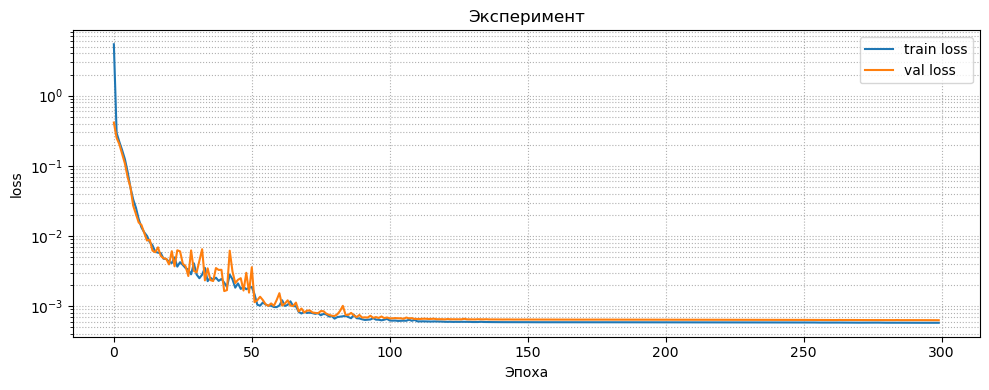

    Пример 1
    Уравнение: x^2 + (1.0) x + (-2.0) = 0
    Дискриминант D = 9.0
    Предсказанные корни: x1=-1.995177+0.005145j, x2=+1.008047+0.003628j
    Настоящие корни: a = +1.000000+0.000000j, b = -2.000000+0.000000j


ValueError: too many values to unpack (expected 2)

In [7]:
if __name__ == "__main__":
    main()